In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import chain

##Import any other packages you may need here

EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Perform the following EDA:
* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Note: use full NIH data to perform the first a few EDA items and use `sample_labels.csv` for the pixel-level assassements. 

Also, **describe your findings and how will you set up the model training based on the findings.**

In [2]:
## Below is some helper code to read data for you.
## Load NIH data
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_xray_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
67469,00016668_004.png,Infiltration,4,16668,64,M,AP,2500,2048,0.168000,0.168000,NaN
109457,00029785_001.png,No Finding,1,29785,36,F,PA,1646,1870,0.194311,0.194311,NaN
81413,00019999_004.png,Atelectasis|Infiltration,4,19999,63,M,PA,2992,2991,0.143000,0.143000,NaN


In [3]:
## Load 'sample_labels.csv' data for pixel level assessments
sample_df = pd.read_csv('sample_labels.csv')
sample_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
1967,00010294_052.png,No Finding,52,10294,050Y,M,AP,2500,2048,0.168,0.168
5489,00029901_002.png,No Finding,2,29901,048Y,M,AP,3056,2544,0.139,0.139
633,00003282_001.png,No Finding,1,3282,042Y,M,PA,2048,2500,0.171,0.171


## EDA

### Prepare data for EDA

In [4]:
# Examine the distribution
all_xray_df.describe()

,Follow-up #,Patient ID,Patient Age,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
count,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,0.0
mean,8.573751,14346.381743,46.901463,2646.078844,2486.438842,0.155649,0.155649,NaN
std,15.406320,8403.876972,16.839923,341.246429,401.268227,0.016174,0.016174,NaN
min,0.000000,1.000000,1.000000,1143.000000,966.000000,0.115000,0.115000,NaN
25%,0.000000,7310.750000,35.000000,2500.000000,2048.000000,0.143000,0.143000,NaN
50%,3.000000,13993.000000,49.000000,2518.000000,2544.000000,0.143000,0.143000,NaN
75%,10.000000,20673.000000,59.000000,2992.000000,2991.000000,0.168000,0.168000,NaN
max,183.000000,30805.000000,414.000000,3827.000000,4715.000000,0.198800,0.198800,NaN


In [5]:
# Discard unnecessary columns
d = all_xray_df.drop(columns=['Follow-up #', 'Unnamed: 11'], axis=1)

The `Patient Age` column seems to have erroneous data. Let's discard unrealistic age data points as well as the extreme age values, so that the images area bit more consistent for the model to work with.

In [6]:
# Retain data where patient age is between 16 and 90
d = d[(d['Patient Age'] >= 16) & (d['Patient Age'] <= 90)]


#### Examine demographic data

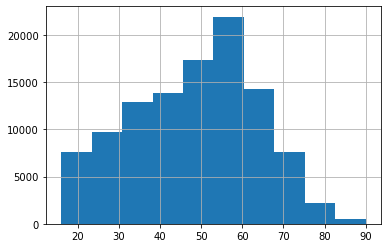

In [7]:
d['Patient Age'].hist()

It appears majority of patients are aged between 16 and 75 years

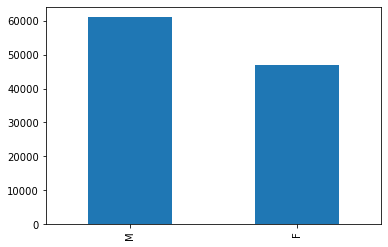

In [8]:
d['Patient Gender'].value_counts().plot(kind='bar')

The gender distribution is slightly tilted towards Male patients.

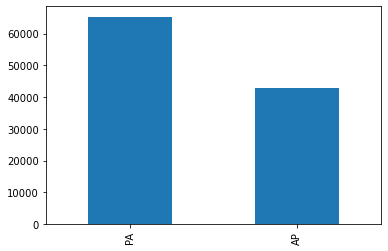

In [9]:
d['View Position'].value_counts().plot(kind='bar')

'PA' view position is larger is number compared to 'AP' view position.

### Split finding labels into separate columns

In [10]:
# Create separate disease label columns from "Finding Labels" column with binary encoding
all_labels = np.unique(list(chain(*list(map(lambda x: x.split('|'), d['Finding Labels'].unique())))))
all_labels = [x for x in all_labels if len(x) > 0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    d[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
        
d.sample(3)


All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
629,00000156_001.png,Cardiomegaly|Effusion,156,81,M,AP,2500,2048,0.171,0.171,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8916,00002350_008.png,Atelectasis,2350,51,F,PA,2992,2991,0.143,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49619,00012603_001.png,No Finding,12603,69,M,PA,2992,2991,0.143,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [11]:
# Check number of images for each label
d[all_labels].sum()

Atelectasis           11286.0
Cardiomegaly           2640.0
Consolidation          4452.0
Edema                  2208.0
Effusion              12992.0
Emphysema              2451.0
Fibrosis               1674.0
Hernia                  227.0
Infiltration          19043.0
Mass                   5639.0
No Finding            58012.0
Nodule                 6210.0
Pleural_Thickening     3293.0
Pneumonia              1346.0
Pneumothorax           5103.0
dtype: float64

In [12]:
# Check percentage share of images for each label
d[all_labels].sum() / len(d)

Atelectasis           0.104387
Cardiomegaly          0.024418
Consolidation         0.041178
Edema                 0.020422
Effusion              0.120166
Emphysema             0.022670
Fibrosis              0.015483
Hernia                0.002100
Infiltration          0.176133
Mass                  0.052156
No Finding            0.536567
Nodule                0.057438
Pleural_Thickening    0.030458
Pneumonia             0.012449
Pneumothorax          0.047199
dtype: float64

[Text(0, 0.5, 'Number of Images with Label')]

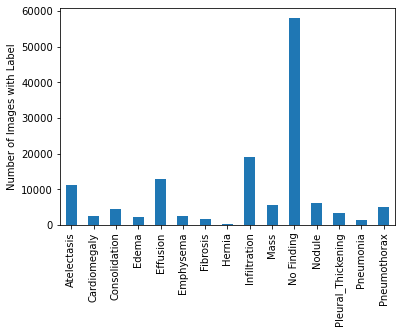

In [13]:
# Visualize image distribution across labels
ax = d[all_labels].sum().plot(kind='bar')
ax.set(ylabel = 'Number of Images with Label')

From the above stats it is apparent that 'No Finding' label or normal images form about 54% while cases for 'Pneumonia' form 1.2%.

In [14]:
print('Number of cases with Pneumonia: ', len(d[d.Pneumonia == 1]))
print('Number of non-pneumonia cases: ', len(d[d.Pneumonia == 0]))

Number of cases with Pneumonia:  1346
Number of non-pneumonia cases:  106771


Above numbers show that there is high imbalance between Pneumonia positive and Pneumonia negative cases. When training the model, we need to balance the dataset by making the number of positive and negative cases equal, so that the model doesn't get biased towards negative cases.

[Text(0, 0.5, 'Distribution of other diseases comorbid with pneumonia')]

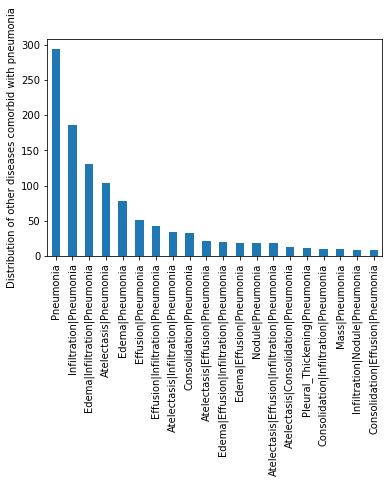

In [15]:
# Distribution of other diseases that are comorbid with pneumonia
ax = d[d['Pneumonia'] == 1]['Finding Labels'].value_counts()[0:20].plot(kind='bar')
ax.set(ylabel = 'Distribution of other diseases comorbid with pneumonia')

Number of cases comorbid with Pneumonia is highest for `Infilration`, followed by `Edema`,`Atelectasis` and `Effusion`

Average number of diseases per patient:  1.5679872268236703


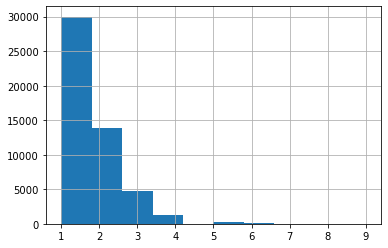

In [16]:
# Number of diseases per patient
num_of_diseases_per_patient = d[all_labels][d['No Finding'] == 0].sum(axis=1)
print('Average number of diseases per patient: ', num_of_diseases_per_patient.mean())
num_of_diseases_per_patient.hist()

If we discard patients with 'No Finding' label as the ones with no (or unknown number of) diseases, then vast majority of patients have 1 to 2 diseases.

### Let's also perform Pixel-level analysis

In [17]:
# Get the image paths for all the sample images
sample_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
sample_df['path'] = sample_df['Image Index'].map(sample_image_paths.get)

In [18]:
sample_df

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139000,0.139000,/data/images_001/images/00000013_005.png
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168000,0.168000,/data/images_001/images/00000013_026.png
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168000,0.168000,/data/images_001/images/00000017_001.png
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143000,0.143000,/data/images_001/images/00000030_001.png
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168000,0.168000,/data/images_001/images/00000032_001.png
...,...,...,...,...,...,...,...,...,...,...,...,...
5601,00030712_000.png,No Finding,0,30712,058Y,M,PA,2021,2021,0.194311,0.194311,/data/images_012/images/00030712_000.png
5602,00030786_005.png,Cardiomegaly|Effusion|Emphysema,5,30786,061Y,F,AP,3056,2544,0.139000,0.139000,/data/images_012/images/00030786_005.png
5603,00030789_000.png,Infiltration,0,30789,052Y,F,PA,2021,2021,0.194311,0.194311,/data/images_012/images/00030789_000.png
5604,00030792_000.png,No Finding,0,30792,010Y,F,PA,1775,1712,0.194311,0.194311,/data/images_012/images/00030792_000.png


#### Select a random sample of images to analyse

In [19]:
# Remove 'No Finding' from list of diseases
disease_labels = [l for l in all_labels if l != 'No Finding']

In [22]:
def show_image_and_intensity_dist(df):
    samples_per_disease = 3
    fig, axs = plt.subplots(len(disease_labels) * samples_per_disease, 2, figsize=(10, 240))
    fig_idx = 0
    for label in disease_labels:
        paths = df.loc[df['Finding Labels'] == label]['path'].sample(samples_per_disease, random_state=42)
        for path in paths:
            img = plt.imread(path)
            axs[fig_idx, 0].imshow(img, cmap='gray')
            axs[fig_idx, 0].set_title(label)
            axs[fig_idx, 1].hist(img.ravel(), bins=256)
            axs[fig_idx, 1].set_title(label)
            fig_idx += 1

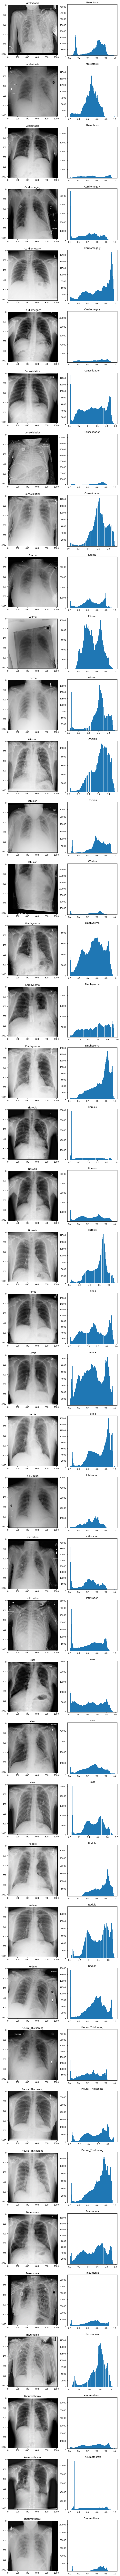

In [23]:
show_image_and_intensity_dist(sample_df)

##### Observations from the above plots:
* The intensity distribution of Pneumonia appears to be quite spread out.
* There are peaks around 0.6 and 0.8 for Pneumonia
* Fibrosis and Pneumothorax sometimes have similar intensity distributions
* Several images have peak around 0 due to black background.
* The distribution within the same disease is not always consistent
* It is not easy to differentiate diseases solely by looking at intensity distribution